In [ ]:
#finding more parameters using MC Mira

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("coolwarm",15)
sns.set_style("whitegrid")

import emcee

In [2]:
file=open( '../../data/raw_data/20160428_1313_W1204_ref.pkl' , 'rb')
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

In [3]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

In [17]:
def findznot(P,T): #this is z_not written as a function of tau
    Znotvec = np.linspace(-.026,.026,150)
    MinzNot = np.zeros((len(Znotvec)))
    for kk in range (0,len(Znotvec)):
        z_not = Znotvec[kk]
        x,Modelf = psi1(z_not,8.57718120805,P, T)
        ModelMin = np.where(Modelf == Modelf.min())
        ModelMin = ModelMin[0]
        ModelMin = ModelMin[0]
        DataMin = np.where(D == D.min())
        DataMin = DataMin[0]
        DataMin = DataMin[0]
        MinzNot[kk] = np.abs(1-(float(ModelMin)/float(DataMin)))
    miin = np.where(MinzNot == MinzNot.min())
    miin = miin[0]
    miin = miin[0]
    BestzNot = Znotvec[miin]
    return BestzNot
findznot(.05,.02)

-0.023208053691275168

In [9]:
def findahat(P,T):
    x,Modelf = psi1(findznot(P,T),8.57718120805,P,T) #z_not, q, p, T
    Mult = np.dot(D,Modelf)
    Mult2 = np.dot(Modelf,Modelf)
    aHat=Mult/Mult2
    return aHat
print findahat(.05,.02)

0.000262840500783


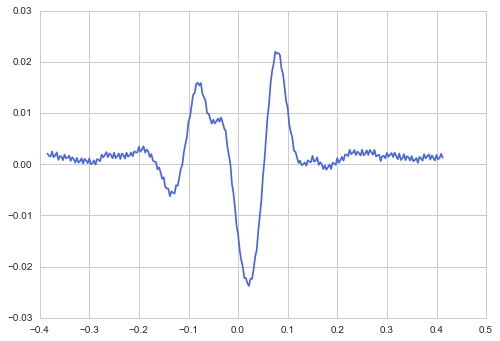

In [10]:
x,Model = psi1(-.02,9,.05,.02)
y = D-Model*.0002
pl.plot(x,y)

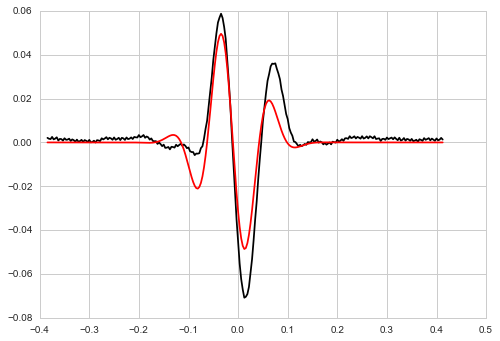

In [11]:
pl.plot(t,D, color = 'black')
pl.plot(x,Model*.0002, color = 'red')

(array([   8.,    4.,    4.,    6.,   17.,  172.,   11.,   16.,   10.,    8.]),
 array([-0.02377019, -0.01919086, -0.01461153, -0.0100322 , -0.00545287,
        -0.00087354,  0.00370579,  0.00828512,  0.01286445,  0.01744378,
         0.02202311]),
 <a list of 10 Patch objects>)

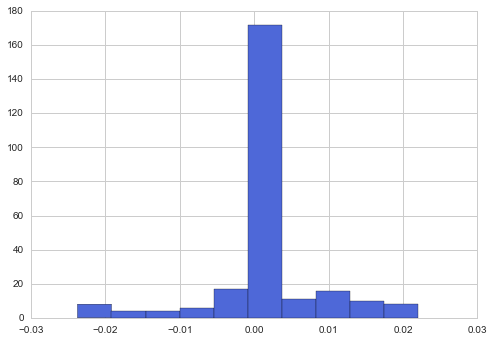

In [12]:
pl.hist(y)

In [13]:
np.std(y)#Max sigma

0.0072912433088457235

In [15]:
np.std(D[:20]) #lowest sigma

0.00053057442001229352